# 1. Setup

## 1.1 Install Dependencies

In [2]:
!pip install tensorflow opencv-python matplotlib

## 1.2 Import Dependencies

In [12]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [4]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

2024-03-22 16:07:56.716317: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-22 16:07:56.716368: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-22 16:07:56.717435: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-22 16:07:56.723310: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-22 16:07:57.821325: W tensorflow/compiler/tf2

## 1.3 Set GPU Growth

In [5]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

## 1.4 Create Folder Structures

In [6]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [7]:
# Make the directories
os.makedirs(POS_PATH, exist_ok=True)
os.makedirs(NEG_PATH, exist_ok=True)
os.makedirs(ANC_PATH, exist_ok=True)

# 2. Collect Positives and Anchors

## 2.1 Untar Labelled Faces in the Wild Dataset

In [1]:
# http://vis-www.cs.umass.edu/lfw/

In [8]:
# Uncompress Tar GZ Labelled Faces in the Wild Dataset
!tar -xf lfw.tgz

In [8]:
# Move LFW Images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

## 2.2 Collect Positive and Anchor Classes

In [9]:
# Import uuid library to generate unique image names
import uuid

In [10]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data/anchor/472788a3-e822-11ee-bf19-c8940282791b.jpg'

In [11]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250, :]
    
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

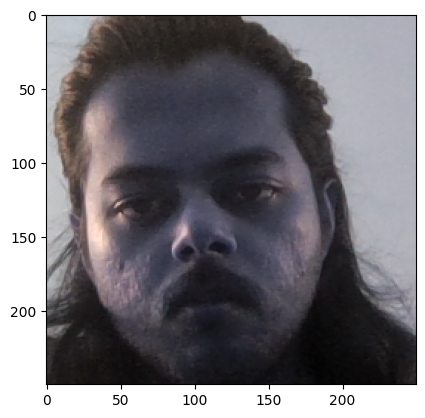

In [12]:
plt.imshow(frame[:, : , :])

# 3. Load and Preprocess Images

## 3.1 Get Image Directories

In [13]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(300)

In [14]:
dir_test = anchor.as_numpy_iterator()

In [15]:
print(dir_test.next())

b'data/anchor/5affe521-b7c7-11ee-8805-c8940282791b.jpg'


## 3.2 Preprocessing - Scale and Resize

In [18]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0
    
    # Return image
    return img

In [18]:
img = preprocess('data/anchor/6a61bac0-b7c7-11ee-b424-c8940282791b.jpg')

In [19]:
img.numpy().max() 

1.0

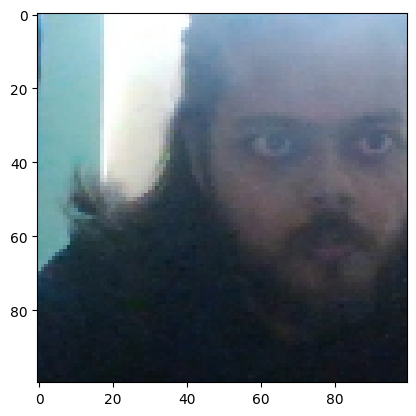

In [20]:
plt.imshow(img)

## 3.3 Create Labelled Dataset

In [21]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

In [22]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [23]:
samples = data.as_numpy_iterator()

In [24]:
exampple = samples.next()

In [25]:
exampple

(b'data/anchor/6a48132c-b7c7-11ee-8a5c-c8940282791b.jpg',
 b'data/positive/4d4496f4-b7c8-11ee-911e-c8940282791b.jpg',
 1.0)

## 3.4 Build Train and Test Partition

In [26]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [27]:
res = preprocess_twin(*exampple)

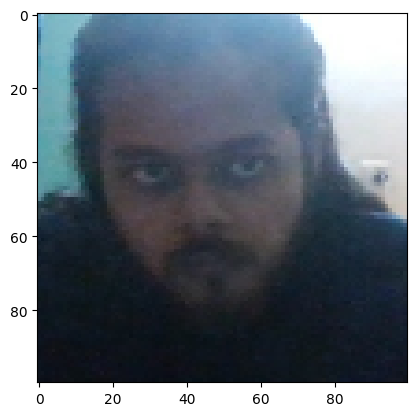

In [28]:
plt.imshow(res[1])

In [29]:
res[2]

1.0

In [30]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [31]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [32]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# 4. Model Engineering

## 4.1 Build Embedding Layer

In [33]:
inp = Input(shape=(100,100,3), name='input_image')

In [34]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)

In [35]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [36]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [37]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [38]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

2024-03-22 13:32:11.894370: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 150994944 exceeds 10% of free system memory.
2024-03-22 13:32:11.928351: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 150994944 exceeds 10% of free system memory.
2024-03-22 13:32:11.951373: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 150994944 exceeds 10% of free system memory.


In [39]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [40]:
mod.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2  (None, 46, 46, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 20, 20, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

In [41]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [42]:
embedding = make_embedding()

2024-03-22 13:32:25.106736: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 150994944 exceeds 10% of free system memory.
2024-03-22 13:32:25.137641: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 150994944 exceeds 10% of free system memory.


In [43]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 46, 46, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 20, 20, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 17, 17, 128)       26

## 4.2 Build Distance Layer

In [7]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [8]:
l1 = L1Dist()

## 4.3 Make Siamese Model

In [46]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [47]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [48]:
siamese_layer = L1Dist()

In [49]:
distances = siamese_layer(inp_embedding, val_embedding)

In [50]:
classifier = Dense(1, activation='sigmoid')(distances)

In [51]:
classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_2')>

In [52]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [53]:
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

In [54]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [55]:
siamese_model = make_siamese_model()

In [56]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

# 5. Training

## 5.1 Setup Loss and Optimizer

In [57]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [58]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

## 5.2 Establish Checkpoints

In [59]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

## 5.3 Build Train Step Function

In [60]:
test_batch = train_data.as_numpy_iterator()

In [61]:
batch_1 = test_batch.next()

In [62]:
X = batch_1[:2]

In [63]:
y = batch_1[2]

In [64]:
y

array([1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0.],
      dtype=float32)

In [65]:
tf.losses.BinaryCrossentropy??

Init signature:
tf.losses.BinaryCrossentropy(
    from_logits=False,
    label_smoothing=0.0,
    axis=-1,
    reduction='auto',
    name='binary_crossentropy',
)
Source:        
@keras_export("keras.losses.BinaryCrossentropy")
class BinaryCrossentropy(LossFunctionWrapper):
    """Computes the cross-entropy loss between true labels and predicted labels.

    Use this cross-entropy loss for binary (0 or 1) classification applications.
    The loss function requires the following inputs:

    - `y_true` (true label): This is either 0 or 1.
    - `y_pred` (predicted value): This is the model's prediction, i.e, a single
        floating-point value which either represents a
        [logit](https://en.wikipedia.org/wiki/Logit), (i.e, value in [-inf, inf]
        when `from_logits=True`) or a probability (i.e, value in [0., 1.] when
        `from_logits=False`).

    **Recommended Usage:** (set `from_logits=True`)

    With `tf.keras` API:

    ```python
    model.compile(
        loss=tf.ke

In [66]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    # Return loss
    return loss

## 5.4 Build Training Loop

In [67]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            train_step(batch)
            progbar.update(idx+1)
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

## 5.5 Train the model

In [68]:
EPOCHS = 50

In [69]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
27/27 [==============================] - 125s 5s/step

 Epoch 2/50
27/27 [==============================] - 121s 4s/step

 Epoch 3/50
27/27 [==============================] - 121s 4s/step

 Epoch 4/50
27/27 [==============================] - 122s 5s/step

 Epoch 5/50
27/27 [==============================] - 122s 5s/step

 Epoch 6/50
27/27 [==============================] - 123s 5s/step

 Epoch 7/50
27/27 [==============================] - 122s 5s/step

 Epoch 8/50
27/27 [==============================] - 122s 5s/step

 Epoch 9/50
27/27 [==============================] - 120s 4s/step

 Epoch 10/50
27/27 [==============================] - 120s 4s/step

 Epoch 11/50
27/27 [==============================] - 117s 4s/step

 Epoch 12/50
27/27 [==============================] - 118s 4s/step

 Epoch 13/50
27/27 [==================

# 6. Evaluate Model

## 6.1 Import Metrics

In [70]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

## 6.2 Make Predictions

In [71]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [72]:
# Make predictions
y_hat = siamese_model.predict([test_input, test_val])
y_hat

1/1 [==============================] - 1s 577ms/step


array([[1.0000000e+00],
       [2.4020064e-08],
       [6.3169509e-08],
       [1.0000000e+00],
       [9.9994445e-01],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [2.6763205e-09],
       [2.5317700e-05],
       [2.1315980e-08],
       [1.8683239e-05],
       [1.0000000e+00],
       [6.0526993e-08],
       [1.0118322e-07],
       [1.7038799e-05]], dtype=float32)

In [73]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0]

In [74]:
y_true

array([1., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
      dtype=float32)

## 6.3 Calculate Metrics

In [75]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [76]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

## 6.4 Viz Results

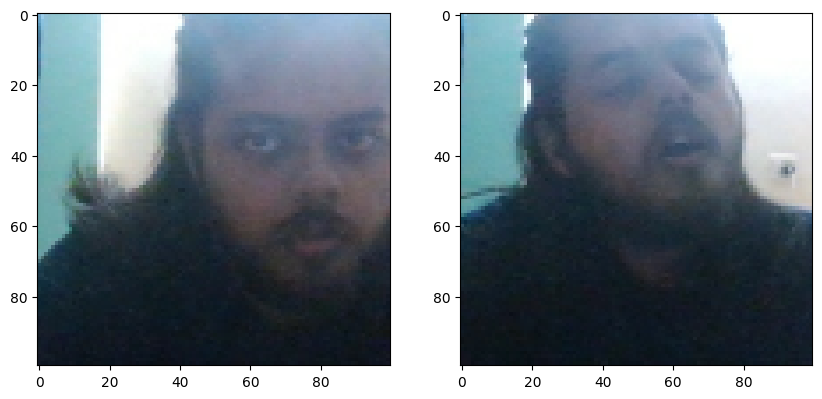

In [77]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()

# 7. Save Model

In [78]:
# Save weights
siamese_model.save('siamesemodelnew.h5')

/home/linuxbrew/.linuxbrew/Cellar/python@3.11/3.11.8/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [9]:
L1Dist

__main__.L1Dist

In [10]:
# Reload model 
model = tf.keras.models.load_model('siamesemodelnew.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [81]:
# Make predictions with reloaded model
model.predict([test_input, test_val])

1/1 [==============================] - 1s 537ms/step


array([[1.0000000e+00],
       [2.4020064e-08],
       [6.3169509e-08],
       [1.0000000e+00],
       [9.9994445e-01],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [2.6763205e-09],
       [2.5317700e-05],
       [2.1315980e-08],
       [1.8683239e-05],
       [1.0000000e+00],
       [6.0526993e-08],
       [1.0118322e-07],
       [1.7038799e-05]], dtype=float32)

In [82]:
# View model summary
model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

# 8. Real Time Test

## 8.1 Verification Function

In [84]:
# application_data/verification_images

In [13]:
os.listdir(os.path.join('application_data', 'verification_images'))

['92eb1273-b7c7-11ee-affd-c8940282791b.jpg',
 '91f24369-b7c7-11ee-9095-c8940282791b.jpg',
 '91642469-b7c7-11ee-898b-c8940282791b.jpg',
 '91c47d6e-b7c7-11ee-a507-c8940282791b.jpg',
 '90fed653-b7c7-11ee-b127-c8940282791b.jpg',
 '90d11d37-b7c7-11ee-8917-c8940282791b.jpg',
 '8cda43a6-b7c7-11ee-81f2-c8940282791b.jpg',
 '8be6c211-b7c7-11ee-9f52-c8940282791b.jpg',
 '8bb8ef5c-b7c7-11ee-a3b5-c8940282791b.jpg',
 '8b2b07a5-b7c7-11ee-9ef8-c8940282791b.jpg',
 '89ae2c8d-b7c7-11ee-8936-c8940282791b.jpg',
 '894de5b7-b7c7-11ee-89c6-c8940282791b.jpg',
 '88ed49ac-b7c7-11ee-8e3a-c8940282791b.jpg',
 '882cc437-b7c7-11ee-af2e-c8940282791b.jpg',
 '87ff046d-b7c7-11ee-a5e2-c8940282791b.jpg',
 '879eae49-b7c7-11ee-8876-c8940282791b.jpg',
 '873e5007-b7c7-11ee-8372-c8940282791b.jpg',
 '86b02b81-b7c7-11ee-ae8a-c8940282791b.jpg',
 '85ea259a-b7c7-11ee-a1ad-c8940282791b.jpg',
 '85b7a140-b7c7-11ee-93ba-c8940282791b.jpg',
 '84c94424-b7c7-11ee-836d-c8940282791b.jpg',
 '84086893-b7c7-11ee-97a6-c8940282791b.jpg',
 '83d5c46e

In [14]:
os.path.join('application_data', 'input_image', 'input_image.jpg')

'application_data/input_image/input_image.jpg'

In [15]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data/verification_images/92eb1273-b7c7-11ee-affd-c8940282791b.jpg
application_data/verification_images/91f24369-b7c7-11ee-9095-c8940282791b.jpg
application_data/verification_images/91642469-b7c7-11ee-898b-c8940282791b.jpg
application_data/verification_images/91c47d6e-b7c7-11ee-a507-c8940282791b.jpg
application_data/verification_images/90fed653-b7c7-11ee-b127-c8940282791b.jpg
application_data/verification_images/90d11d37-b7c7-11ee-8917-c8940282791b.jpg
application_data/verification_images/8cda43a6-b7c7-11ee-81f2-c8940282791b.jpg
application_data/verification_images/8be6c211-b7c7-11ee-9f52-c8940282791b.jpg
application_data/verification_images/8bb8ef5c-b7c7-11ee-a3b5-c8940282791b.jpg
application_data/verification_images/8b2b07a5-b7c7-11ee-9ef8-c8940282791b.jpg
application_data/verification_images/89ae2c8d-b7c7-11ee-8936-c8940282791b.jpg
application_data/verification_images/894de5b7-b7c7-11ee-89c6-c8940282791b.jpg
application_data/verification_images/88ed49ac-b7c7-11ee-8e3a-c89

In [16]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

## 8.2 OpenCV Real Time Verification

In [22]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(model, 0.5, 0.7)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 99ms/step
False


In [21]:
results

[array([[0.86717576]], dtype=float32),
 array([[0.7925528]], dtype=float32),
 array([[0.93897045]], dtype=float32),
 array([[0.7113884]], dtype=float32),
 array([[0.93886465]], dtype=float32),
 array([[0.9362306]], dtype=float32),
 array([[0.99999994]], dtype=float32),
 array([[0.7529171]], dtype=float32),
 array([[0.68058246]], dtype=float32),
 array([[0.8269128]], dtype=float32),
 array([[0.86881304]], dtype=float32),
 array([[0.6278768]], dtype=float32),
 array([[0.81284183]], dtype=float32),
 array([[0.9999997]], dtype=float32),
 array([[0.9999931]], dtype=float32),
 array([[0.99987537]], dtype=float32),
 array([[0.53199404]], dtype=float32),
 array([[0.22217026]], dtype=float32),
 array([[0.18687347]], dtype=float32),
 array([[0.18398792]], dtype=float32),
 array([[0.22449769]], dtype=float32),
 array([[0.20923932]], dtype=float32),
 array([[0.19741516]], dtype=float32),
 array([[0.24606891]], dtype=float32),
 array([[0.5765945]], dtype=float32),
 array([[0.35896003]], dtype=float

In [90]:
np.sum(np.squeeze(results) > 0.9)

20

In [91]:
32/50

0.64